## __Importing Libraries:__

In [1]:
#Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

## __Processing the Dataset:__

In [2]:
# Reading in the dataset and cleaning it up
star_dataset = pd.read_csv("cleaned_star_data.csv")
star_dataset.replace(' ', np.nan, inplace=True)    #Replacing all blank spaces with NaN
star_dataset.dropna(inplace=True)    #Dropping all NaN
star_dataset.reset_index(drop=True, inplace=True) #Resetting the indexing to be consistent

# Encoding and combining the processed dataframes
ordEncoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])    #Setting the encoder for the ordinal data
ordinal_dataset = star_dataset.copy()
ordinal_dataset['Spectral Class'] = ordEncoder.fit_transform(star_dataset[['Spectral Class']])    #Transforming the dataset using the ordinal encoder
oneHot = OneHotEncoder(dtype=int)    #Setting up the encoder for the nominal data
nominal = pd.DataFrame(oneHot.fit_transform(star_dataset[['Star color']]).toarray(), columns=['Blue', 'Blue-White', 'Red', 'White', 'Yellow-White'])    #Creating a new dataframe and transforming the nominal data using the OneHotEncoder
processed_dataframe = pd.concat([ordinal_dataset, nominal], axis=1)    #Concatenating the two dataframes into one fully processed dataframes
processed_dataframe.drop('Star color', axis=1, inplace=True)

## __Research Question 1:__
* What is the correlation between luminosity and temperature, and luminosity and radius of the dataset? Does the resulting correlation coefficient make sense given the formula for luminosity?

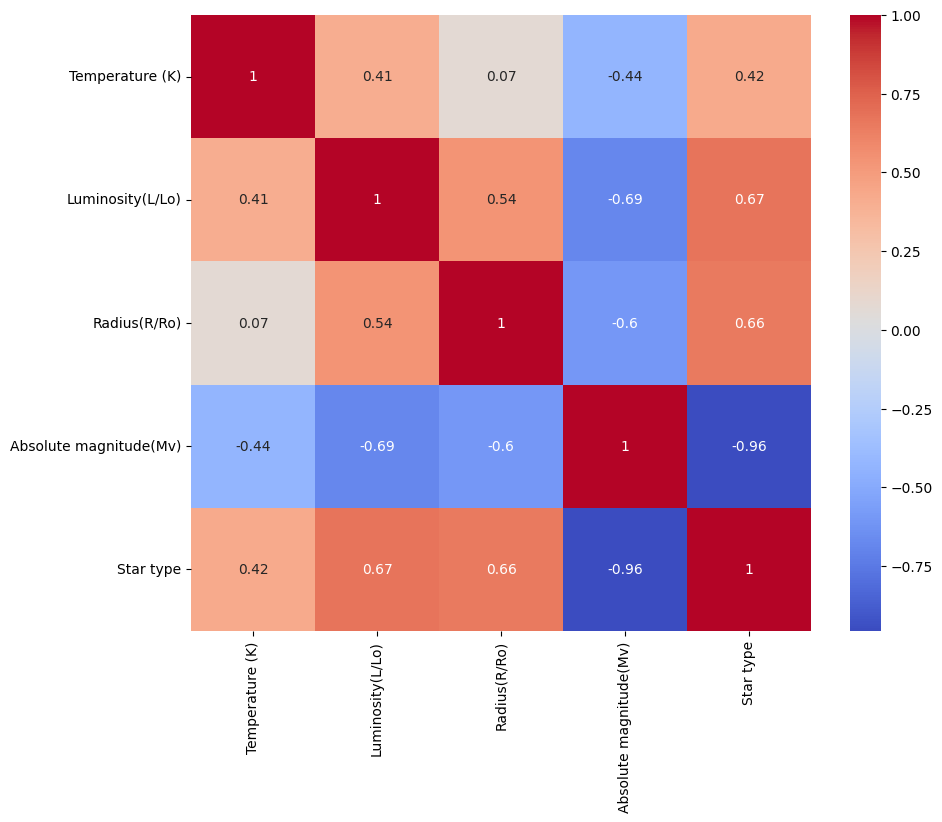

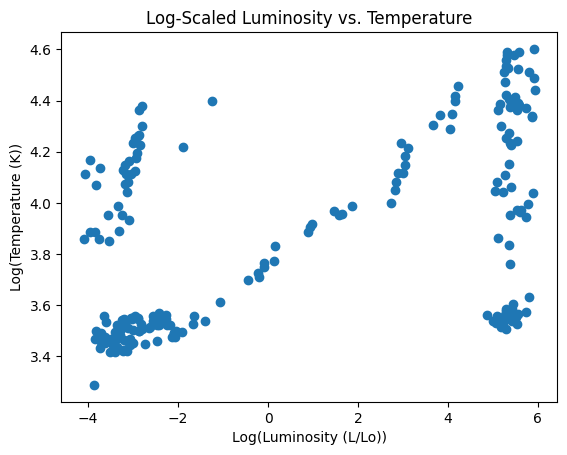

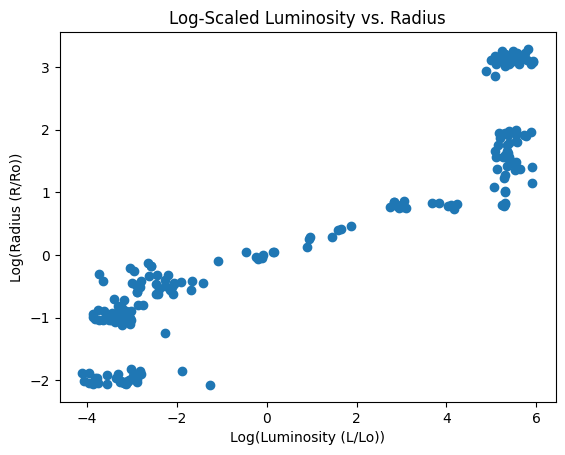

In [3]:
#The code for the heatmap was gathered by Devra AI on Kaggle https://www.kaggle.com/code/devraai/exploring-astronomical-data-with-machine-learning
star_dataset['Temperature (K)'] = pd.to_numeric(star_dataset['Temperature (K)'], errors='coerce')
star_dataset['Luminosity(L/Lo)'] = pd.to_numeric(star_dataset['Luminosity(L/Lo)'], errors='coerce')
star_dataset['Radius(R/Ro)'] = pd.to_numeric(star_dataset['Radius(R/Ro)'], errors='coerce')
star_dataset['Absolute magnitude(Mv)'] = pd.to_numeric(star_dataset['Absolute magnitude(Mv)'], errors='coerce')

numeric_df = star_dataset.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

#Plotting luminosity and temperature to see patterns
plt.scatter(np.log10(star_dataset['Luminosity(L/Lo)']), np.log10(star_dataset['Temperature (K)']))    #Applying a log scaler to make the relationship almost linear
plt.xlabel('Log(Luminosity (L/Lo))')
plt.ylabel('Log(Temperature (K))')
plt.title('Log-Scaled Luminosity vs. Temperature')
plt.show()

#Plotting luminosity and radius to see patterns
plt.scatter(np.log10(star_dataset['Luminosity(L/Lo)']), np.log10(star_dataset['Radius(R/Ro)']))    #Applying a log scaler to make the relationship almost linear
plt.xlabel('Log(Luminosity (L/Lo))')
plt.ylabel('Log(Radius (R/Ro))')
plt.title('Log-Scaled Luminosity vs. Radius')
plt.show()

## __Research Question 2:__
* Can we build a decision tree model to predict the type of star given its characteristics such as temperature, luminosity, radius, absolute magnitude, star color, and spectral class?

C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 4, 'max_features': 0.6, 'max_leaf_nodes': 10} 

Best training accuracy:  0.9314814814814815
Test set accuracy of best model:  0.8837209302325582


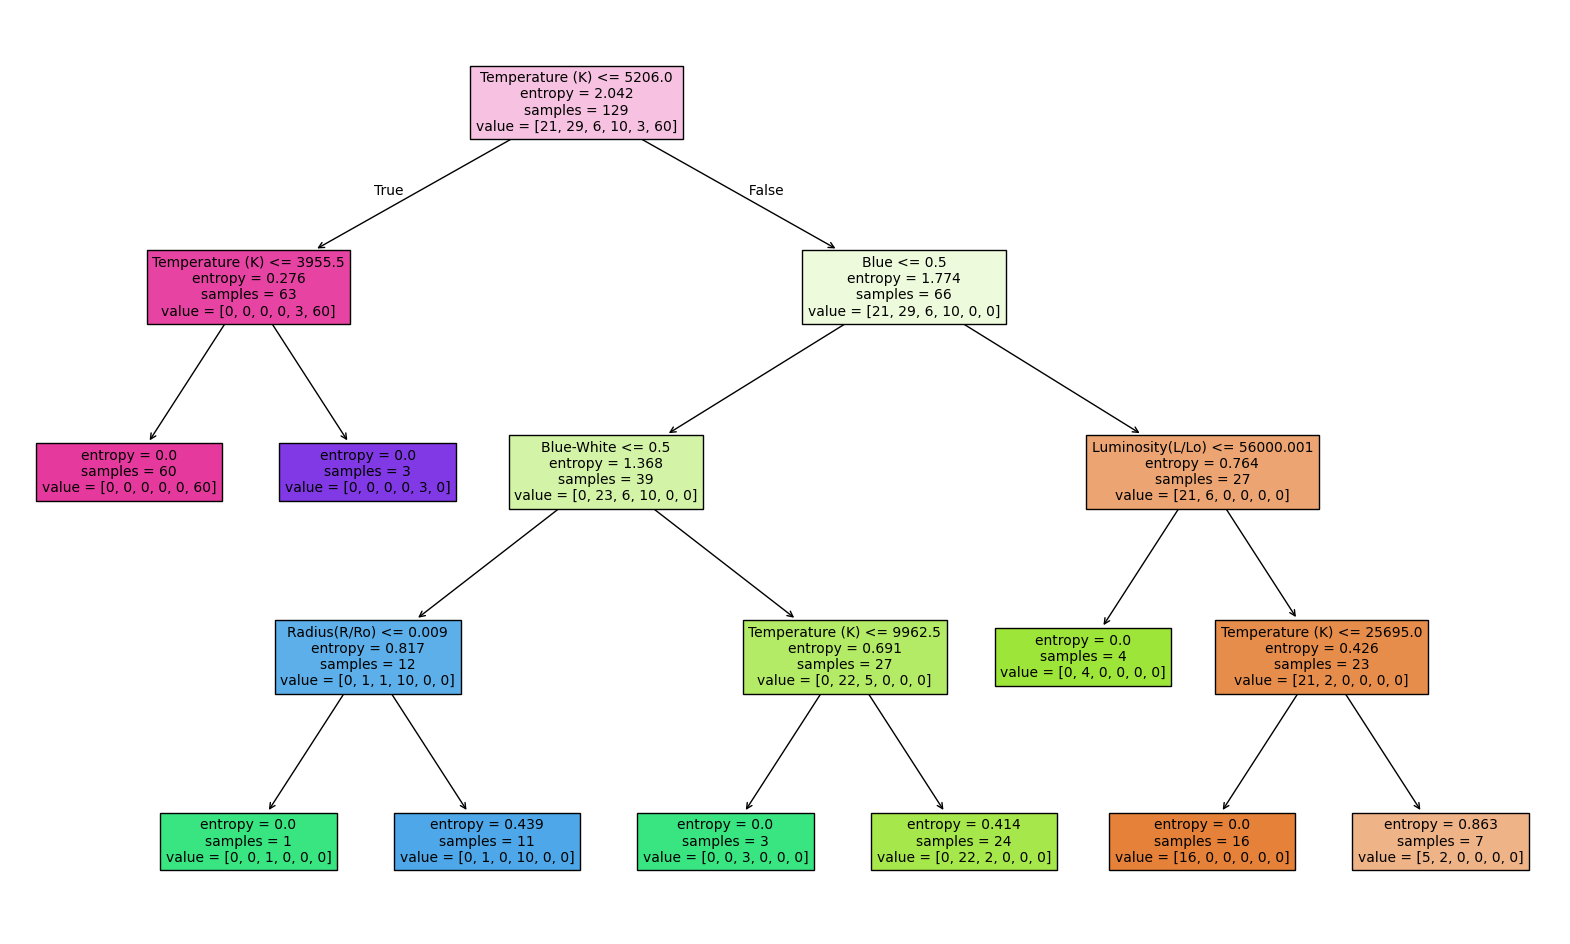

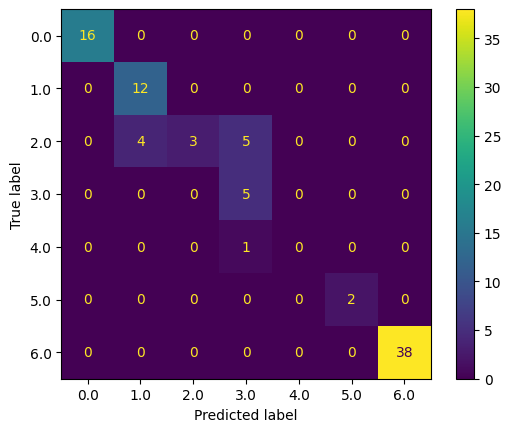


Precision:  0.9217758985200847
Recall:  0.8837209302325582
F1 Score:  0.8629152823920266
                  Feature  Importance
0         Temperature (K)    0.654698
5                    Blue    0.177591
6              Blue-White    0.102606
1        Luminosity(L/Lo)    0.044638
2            Radius(R/Ro)    0.020467
3  Absolute magnitude(Mv)    0.000000
4               Star type    0.000000
7                     Red    0.000000
8                   White    0.000000
9            Yellow-White    0.000000


C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


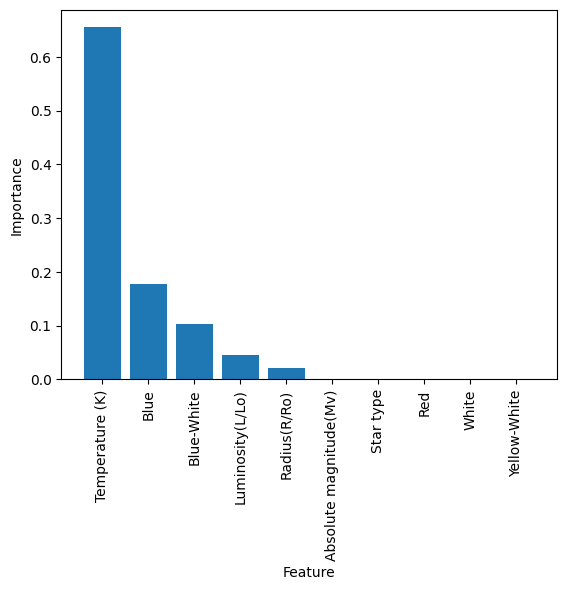

In [4]:
#Seperating the input and output features
x = processed_dataframe.drop(columns=['Spectral Class'])
y = processed_dataframe['Spectral Class']

#Seperating the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=90)

#Setting up the DecisionTreeClassifier and the GridSearchCV for hyperparameter tuning
decisionTree = DecisionTreeClassifier(random_state=101)
params_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes':[5, 10, 15, 20], 'max_features': [None, 0.2, 0.4, 0.6, 0.8]}
decisionTree_gscv = GridSearchCV(estimator=decisionTree, param_grid=params_dt, scoring='accuracy', cv=15)

#Running the model and finding optimal parameters
decisionTree_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = decisionTree_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Printing the test and training accuracy
best_CV_score = decisionTree_gscv.best_score_    #Getting the best training accuracy and printing it
print('Best training accuracy: ', best_CV_score)
best_model = decisionTree_gscv.best_estimator_    #Getting the best model and running the model on the test data and printing the accuracy
test_acc = best_model.score(x_test,y_test)
print("Test set accuracy of best model: ", test_acc)

#Plotting the tree from the best model
plt.figure(figsize=[20, 12])
p = tree.plot_tree(best_model, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Getting the predictions from the best model
y_pred_spectral = best_model.predict(x_test)

#Printing the confusion matrix, precision, recall, and f1 score of the best model
metrics.confusion_matrix(y_test, y_pred_spectral)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_spectral)
plt.show()
print()
precision = precision_score(y_test, best_model.predict(x_test), average='weighted')
recall = recall_score(y_test, best_model.predict(x_test), average='weighted')
f1 = f1_score(y_test, best_model.predict(x_test), average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

#Getting the feature importance of this model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## __Research Question 3:__
* How many features of a star are needed to have a decision tree model accuracy above 80%?

### Removing temperature

C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.8, 'max_leaf_nodes': 10} 

Best training accuracy:  0.924074074074074
Test set accuracy of best model:  0.8604651162790697


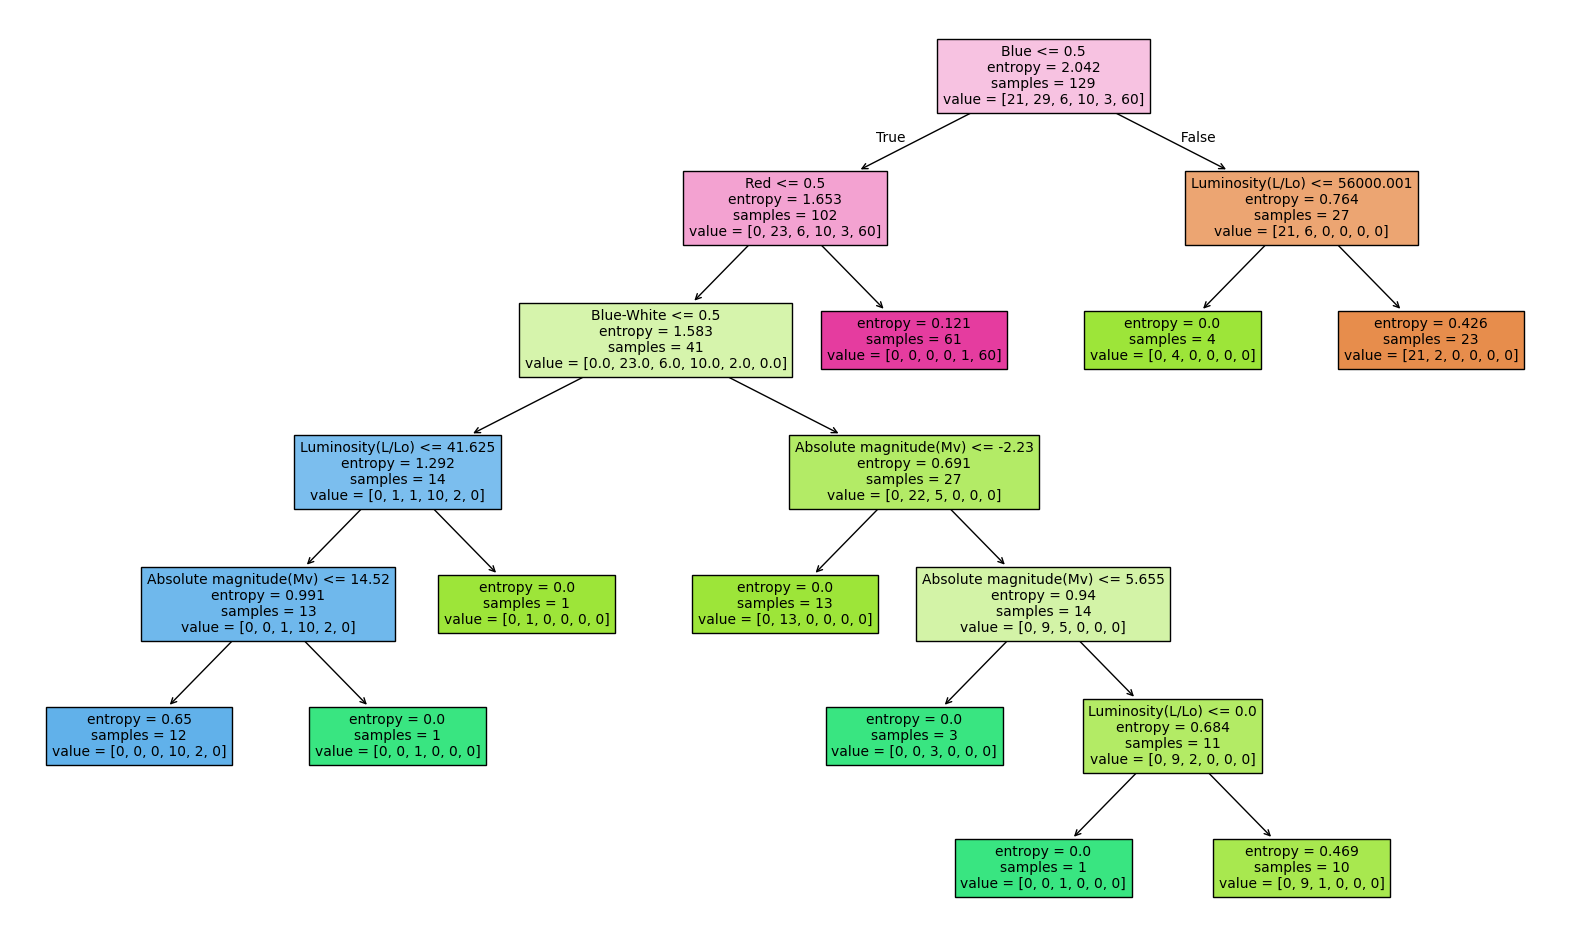

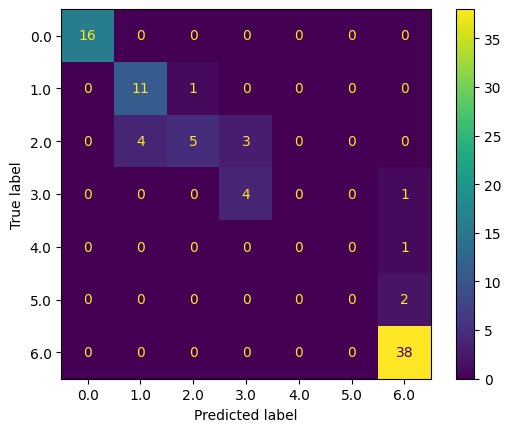


Precision:  0.8376522702104096
Recall:  0.8604651162790697
F1 Score:  0.8357881136950904
                  Feature  Importance
6                     Red    0.412352
4                    Blue    0.317181
5              Blue-White    0.120372
0        Luminosity(L/Lo)    0.080684
2  Absolute magnitude(Mv)    0.069411
1            Radius(R/Ro)    0.000000
3               Star type    0.000000
7                   White    0.000000
8            Yellow-White    0.000000


C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


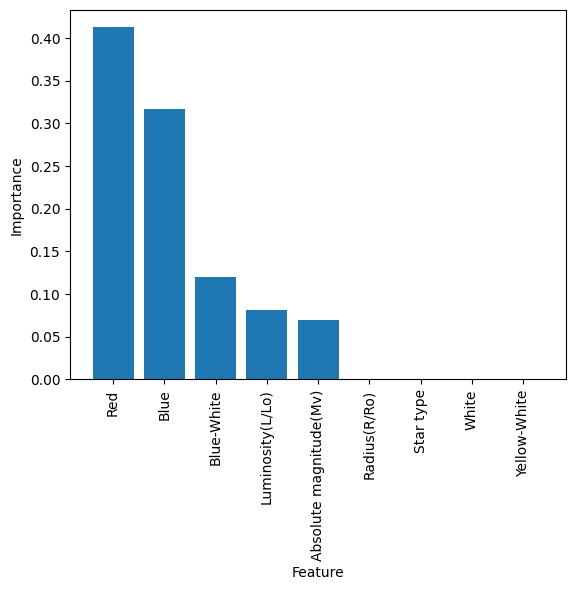

In [5]:
#Seperating the input and output features
x = processed_dataframe.drop(columns=['Spectral Class', 'Temperature (K)'])
y = processed_dataframe['Spectral Class']

#Seperating the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=90)

#Setting up the DecisionTreeClassifier and the GridSearchCV for hyperparameter tuning
decisionTree = DecisionTreeClassifier(random_state=101)
params_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes':[5, 10, 15, 20], 'max_features': [None, 0.2, 0.4, 0.6, 0.8]}
decisionTree_gscv = GridSearchCV(estimator=decisionTree, param_grid=params_dt, scoring='accuracy', cv=15)

#Running the model and finding optimal parameters
decisionTree_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = decisionTree_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Printing the test and training accuracy
best_CV_score = decisionTree_gscv.best_score_    #Getting the best training accuracy and printing it
print('Best training accuracy: ', best_CV_score)
best_model = decisionTree_gscv.best_estimator_    #Getting the best model and running the model on the test data and printing the accuracy
test_acc = best_model.score(x_test,y_test)
print("Test set accuracy of best model: ", test_acc)

#Plotting the tree from the best model
plt.figure(figsize=[20, 12])
p = tree.plot_tree(best_model, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Getting the predictions from the best model
y_pred = best_model.predict(x_test)

#Printing the confusion matrix, precision, recall, and f1 score of the best model
metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
precision = precision_score(y_test, best_model.predict(x_test), average='weighted')
recall = recall_score(y_test, best_model.predict(x_test), average='weighted')
f1 = f1_score(y_test, best_model.predict(x_test), average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

#Getting the feature importance of this model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

### Removing temperature and red

C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 15} 

Best training accuracy:  0.9166666666666666
Test set accuracy of best model:  0.8604651162790697


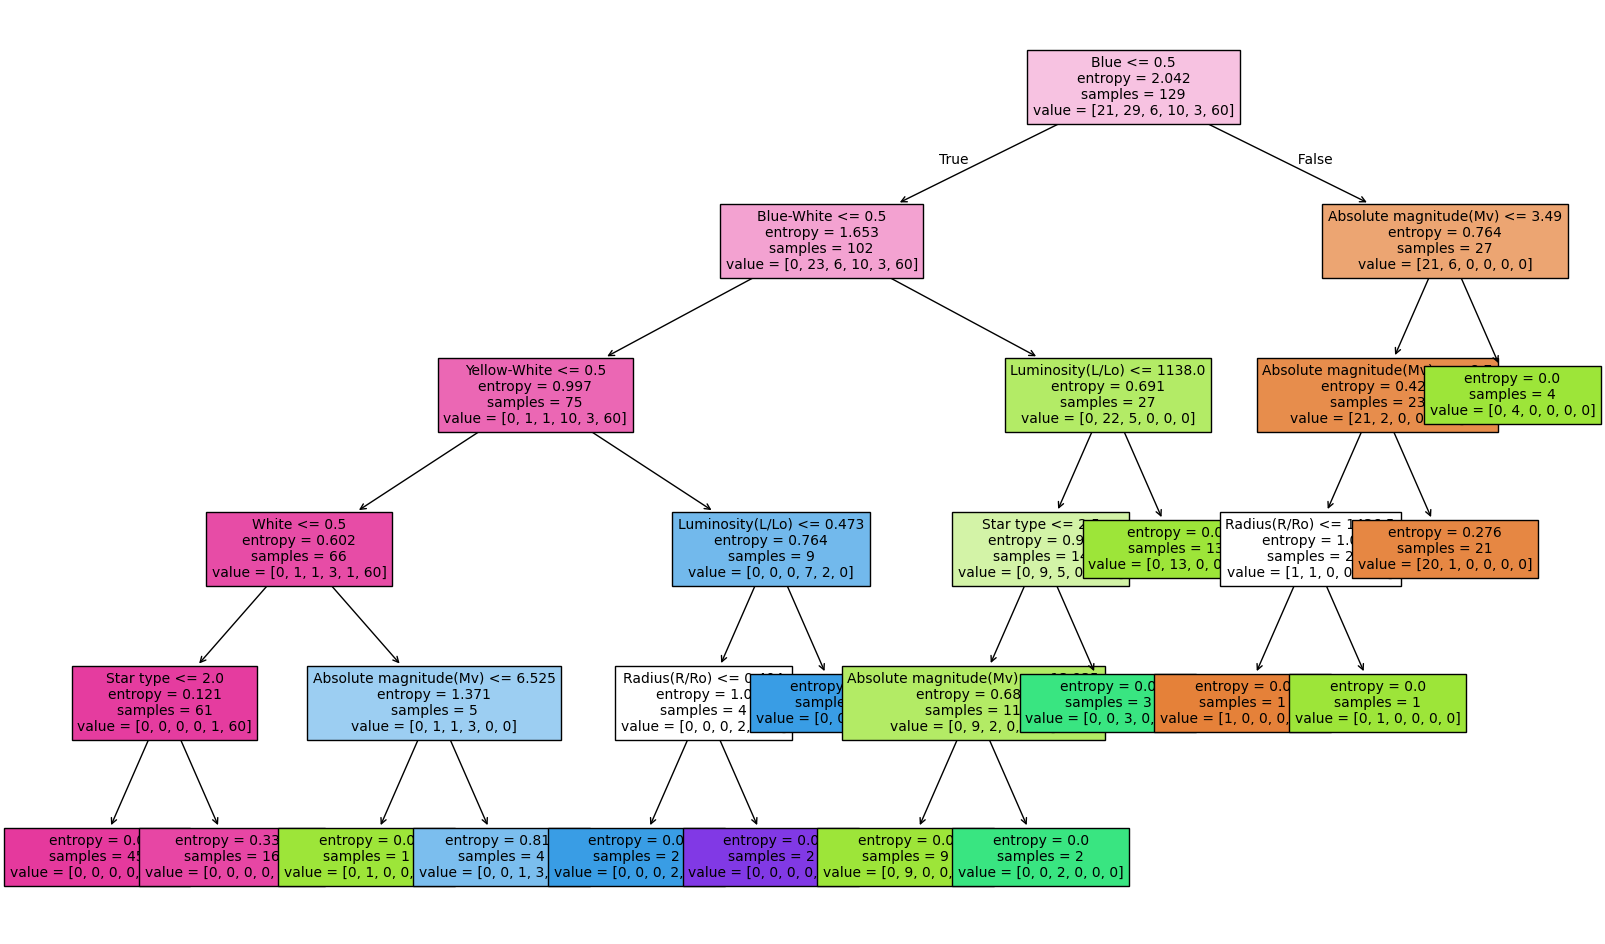

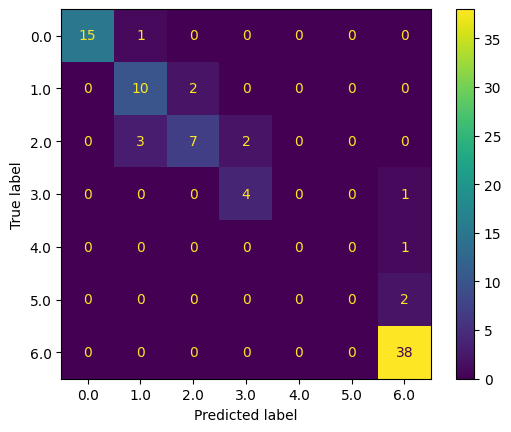


Precision:  0.832779623477298
Recall:  0.8604651162790697
F1 Score:  0.8424535329636604
                  Feature  Importance
5              Blue-White    0.302059
4                    Blue    0.297801
7            Yellow-White    0.112994
6                   White    0.102596
2  Absolute magnitude(Mv)    0.096259
0        Luminosity(L/Lo)    0.033651
3               Star type    0.030541
1            Radius(R/Ro)    0.024097


C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


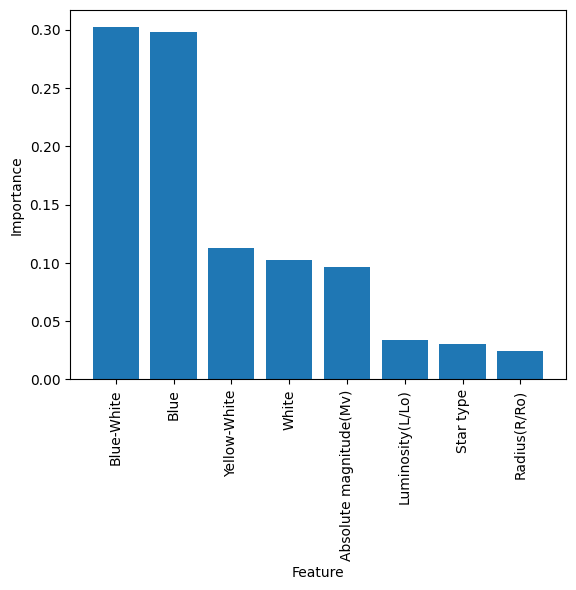

In [6]:
#Seperating the input and output features
x = processed_dataframe.drop(columns=['Spectral Class', 'Temperature (K)', 'Red'])
y = processed_dataframe['Spectral Class']

#Seperating the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=90)

#Setting up the DecisionTreeClassifier and the GridSearchCV for hyperparameter tuning
decisionTree = DecisionTreeClassifier(random_state=101)
params_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes':[5, 10, 15, 20], 'max_features': [None, 0.2, 0.4, 0.6, 0.8]}
decisionTree_gscv = GridSearchCV(estimator=decisionTree, param_grid=params_dt, scoring='accuracy', cv=15)

#Running the model and finding optimal parameters
decisionTree_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = decisionTree_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Printing the test and training accuracy
best_CV_score = decisionTree_gscv.best_score_    #Getting the best training accuracy and printing it
print('Best training accuracy: ', best_CV_score)
best_model = decisionTree_gscv.best_estimator_    #Getting the best model and running the model on the test data and printing the accuracy
test_acc = best_model.score(x_test,y_test)
print("Test set accuracy of best model: ", test_acc)

#Plotting the tree from the best model
plt.figure(figsize=[20, 12])
p = tree.plot_tree(best_model, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Getting the predictions from the best model
y_pred = best_model.predict(x_test)

#Printing the confusion matrix, precision, recall, and f1 score of the best model
metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
precision = precision_score(y_test, best_model.predict(x_test), average='weighted')
recall = recall_score(y_test, best_model.predict(x_test), average='weighted')
f1 = f1_score(y_test, best_model.predict(x_test), average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

#Getting the feature importance of this model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

### Removing temperature, red, and blue-white

C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


Best hyerparameters:
 {'criterion': 'entropy', 'max_depth': 6, 'max_features': 0.4, 'max_leaf_nodes': 10} 

Best training accuracy:  0.8555555555555555
Test set accuracy of best model:  0.7906976744186046


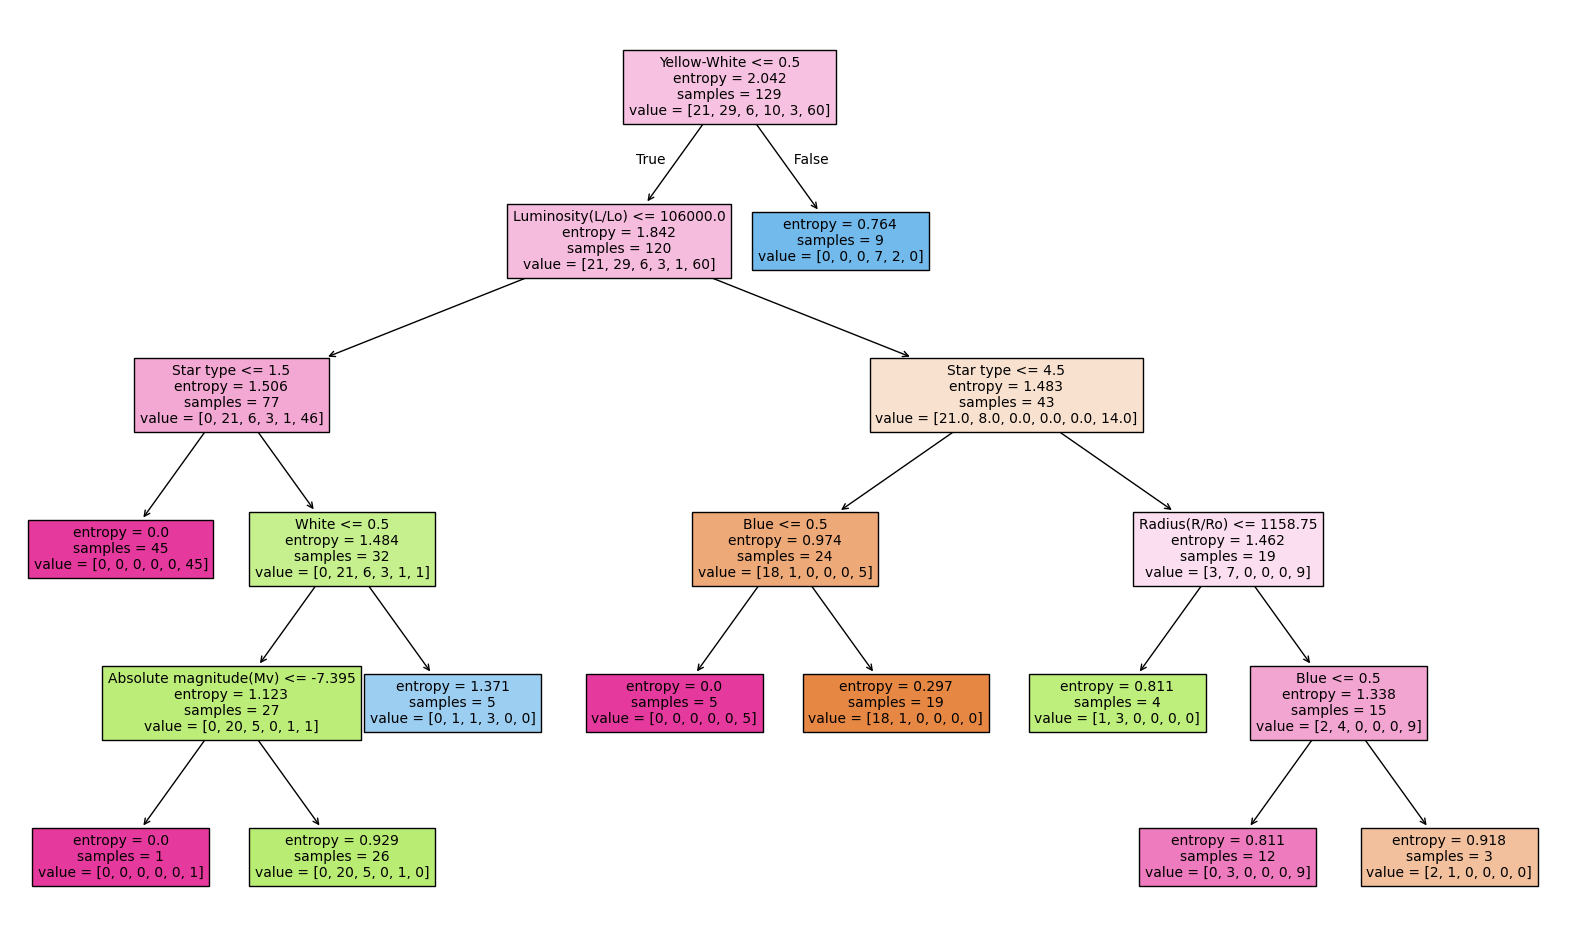

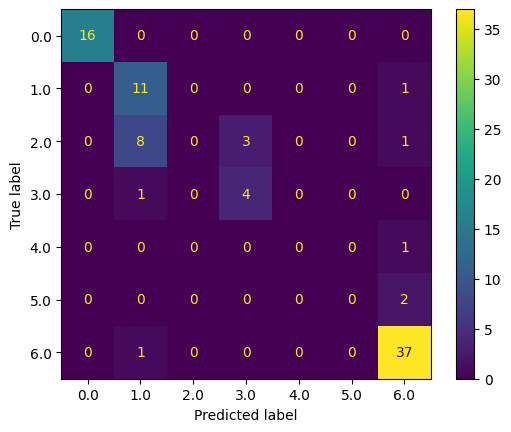


Precision:  0.6816168327796235
Recall:  0.7906976744186046
F1 Score:  0.7265503875968993
                  Feature  Importance
3               Star type    0.397265
0        Luminosity(L/Lo)    0.202234
6            Yellow-White    0.174013
4                    Blue    0.123943
5                   White    0.050494
2  Absolute magnitude(Mv)    0.030226
1            Radius(R/Ro)    0.021826


C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


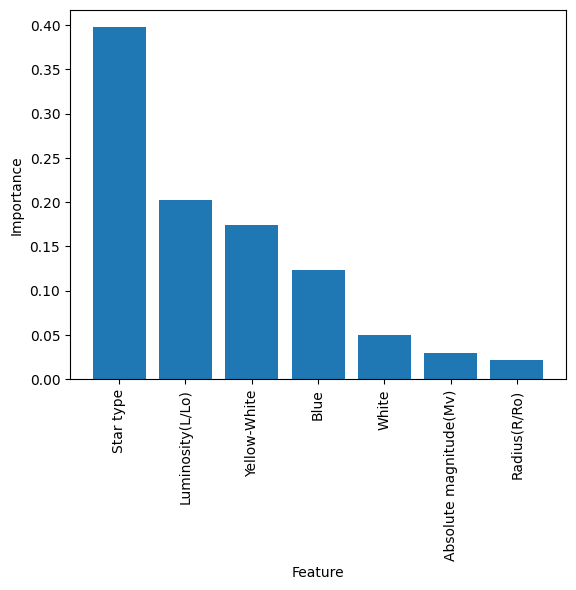

In [7]:
#Seperating the input and output features
x = processed_dataframe.drop(columns=['Spectral Class', 'Temperature (K)', 'Red', 'Blue-White'])
y = processed_dataframe['Spectral Class']

#Seperating the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=90)

#Setting up the DecisionTreeClassifier and the GridSearchCV for hyperparameter tuning
decisionTree = DecisionTreeClassifier(random_state=101)
params_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8], 'max_leaf_nodes':[5, 10, 15, 20], 'max_features': [None, 0.2, 0.4, 0.6, 0.8]}
decisionTree_gscv = GridSearchCV(estimator=decisionTree, param_grid=params_dt, scoring='accuracy', cv=15)

#Running the model and finding optimal parameters
decisionTree_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = decisionTree_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Printing the test and training accuracy
best_CV_score = decisionTree_gscv.best_score_    #Getting the best training accuracy and printing it
print('Best training accuracy: ', best_CV_score)
best_model = decisionTree_gscv.best_estimator_    #Getting the best model and running the model on the test data and printing the accuracy
test_acc = best_model.score(x_test,y_test)
print("Test set accuracy of best model: ", test_acc)

#Plotting the tree from the best model
plt.figure(figsize=[20, 12])
p = tree.plot_tree(best_model, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Getting the predictions from the best model
y_pred = best_model.predict(x_test)

#Printing the confusion matrix, precision, recall, and f1 score of the best model
metrics.confusion_matrix(y_test, y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
print()
precision = precision_score(y_test, best_model.predict(x_test), average='weighted')
recall = recall_score(y_test, best_model.predict(x_test), average='weighted')
f1 = f1_score(y_test, best_model.predict(x_test), average='weighted')
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

#Getting the feature importance of this model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## __Research Question 4:__
* Can we build a model that predicts the absolute magnitude of a star given its characteristics such as temperature, luminosity, radius, star color, star type, and spectral class?

Best hyerparameters:
 {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 30, 'n_estimators': 25} 



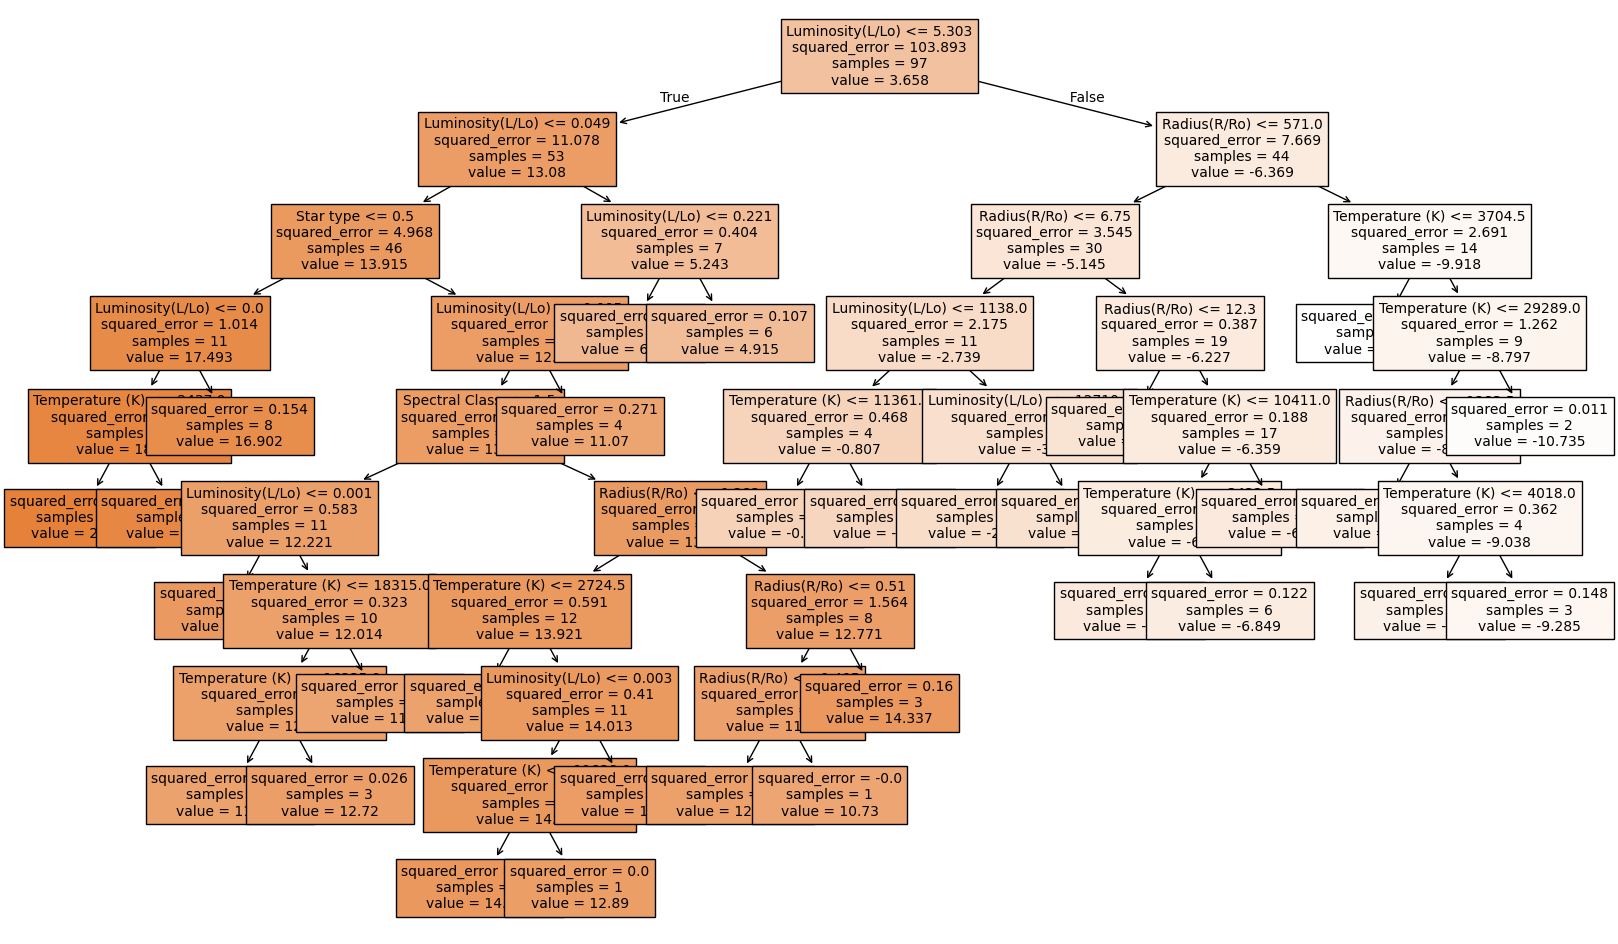

MSE of Training:  1.2476294737473355
RMSE of Training: 1.1169733540901212
R^2 of Training:  0.9973829421349586
MSE of Testing:  1.734629445271247
RMSE of Testing: 1.3170533190692193
R^2 of Testing:  0.9838734080684839
            Feature  Importance
1  Luminosity(L/Lo)    0.670965
2      Radius(R/Ro)    0.277435
3         Star type    0.046203
0   Temperature (K)    0.004553
4    Spectral Class    0.000717
6        Blue-White    0.000055
5              Blue    0.000036
7               Red    0.000020
9      Yellow-White    0.000015
8             White    0.000000


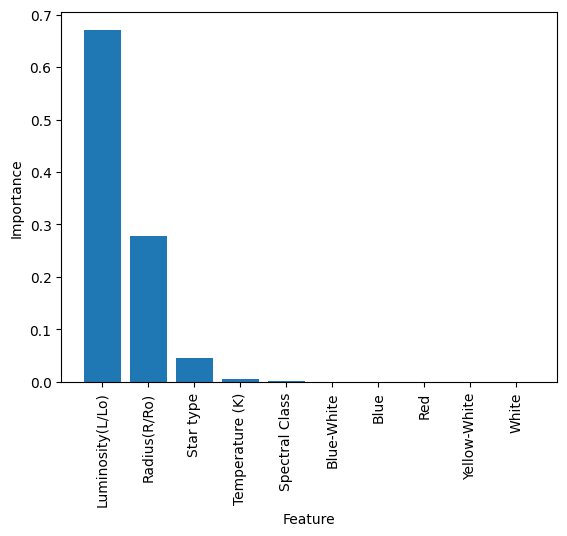

In [9]:
#Splitting the data into input and output features
x = processed_dataframe.drop(columns=['Absolute magnitude(Mv)'])
y = processed_dataframe['Absolute magnitude(Mv)']

#Splitting the dataset into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=90)

#Initializing the RandomForestRegressor
randomForest = RandomForestRegressor(random_state=99)

#Setting up the parameters to try during hyperparameter tuning and initializing the GridSearchCV
params_dt = {'n_estimators': [25, 50], 'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 6, 9], 'max_leaf_nodes': [None, 10, 20, 30, 40]} 
randomForest_gscv = GridSearchCV(estimator=randomForest, param_grid=params_dt, scoring='neg_mean_squared_error', cv=5)

#Running the model and finding optimal parameters
randomForest_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = randomForest_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Getting the best model and the predictions from it
best_model = randomForest_gscv.best_estimator_
single_tree = randomForest_gscv.best_estimator_[0]
y_pred_magnitude = best_model.predict(x_test)

#Plotting one of the random forest trees
plt.figure(figsize=[20, 12])
p = tree.plot_tree(single_tree, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Printing the MSE, RMSE, and R^2 of the training and testing data
best_CV_score = randomForest_gscv.best_score_    #Getting the best MSE and printing it
print('MSE of Training: ', abs(best_CV_score))
rmseTrain = np.sqrt(abs(best_CV_score))
print("RMSE of Training:", rmseTrain)
train_r = best_model.score(x_train, y_train)
print("R^2 of Training: ", train_r)
mseTest = metrics.mean_squared_error(y_pred_magnitude, y_test)
print("MSE of Testing: ", mseTest)
rmseTest = np.sqrt(mseTest)
print("RMSE of Testing:", rmseTest)
test_r = best_model.score(x_test,y_test)
print("R^2 of Testing: ", test_r)

#Getting the feature importance of the model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

## __Research Question 5:__
* How many features of the dataset can be removed before the R^2 of the model falls below 80%?

### Removing luminosity

Best hyerparameters:
 {'max_depth': 9, 'max_features': None, 'max_leaf_nodes': 20, 'n_estimators': 50} 



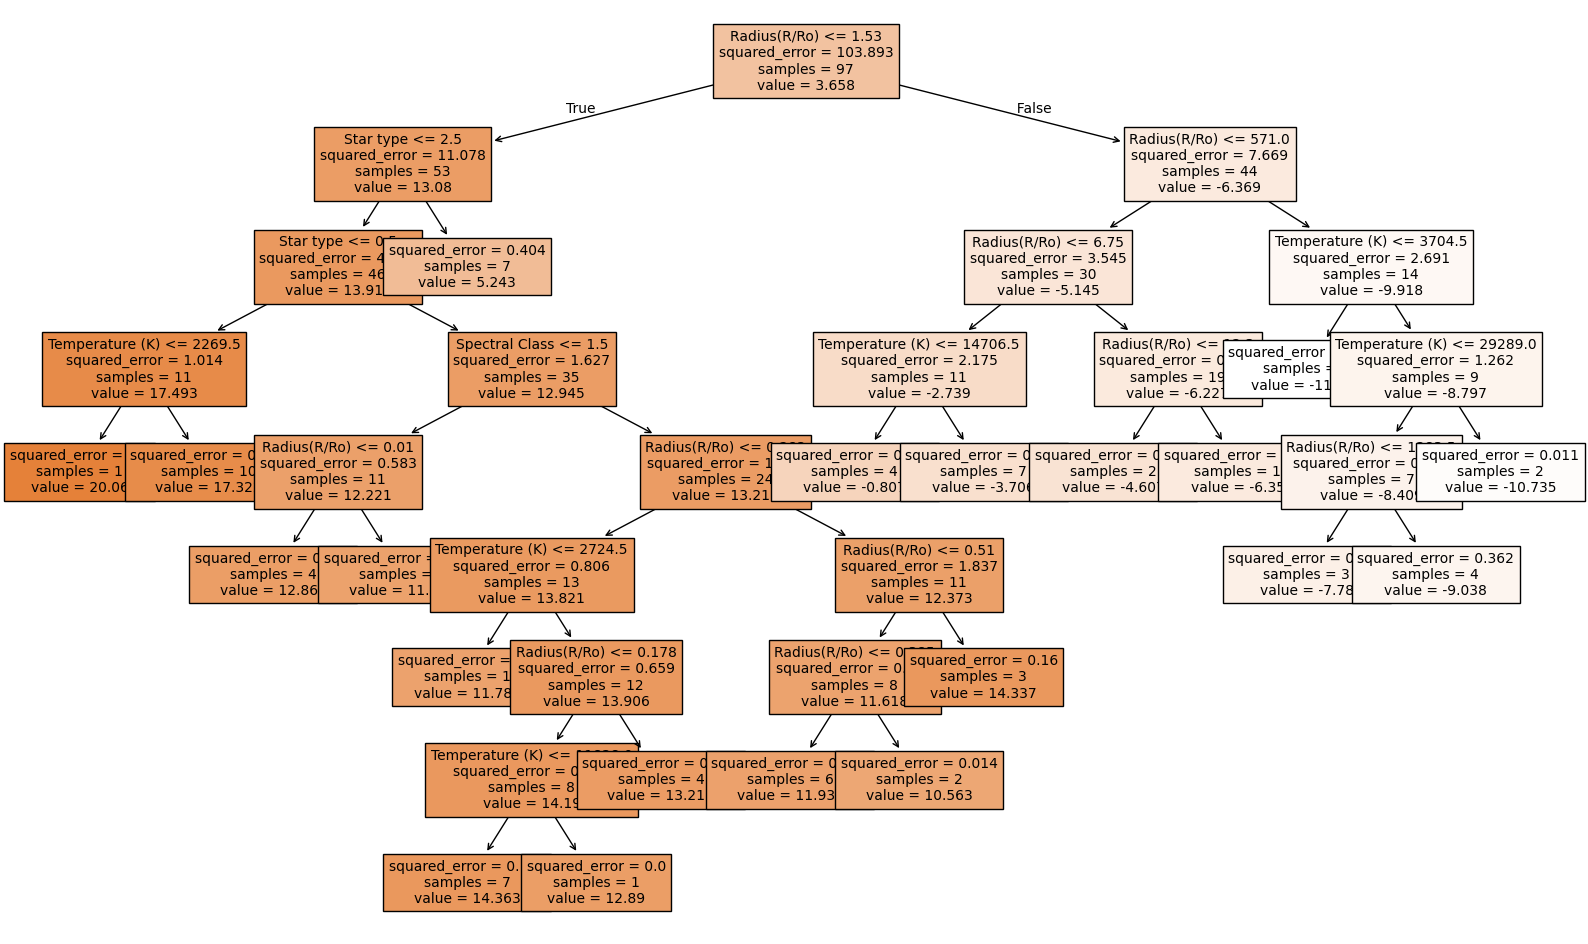

MSE of Training:  1.2764920262163737
RMSE of Training: 1.1298194662052756
R^2 of Training:  0.9959423035934892
MSE of Testing:  1.8612741993860362
RMSE of Testing: 1.3642852338811104
R^2 of Testing:  0.9826960106275239
           Feature  Importance
1     Radius(R/Ro)    0.937829
2        Star type    0.055565
0  Temperature (K)    0.005493
3   Spectral Class    0.000914
8     Yellow-White    0.000080
5       Blue-White    0.000047
6              Red    0.000036
4             Blue    0.000018
7            White    0.000017


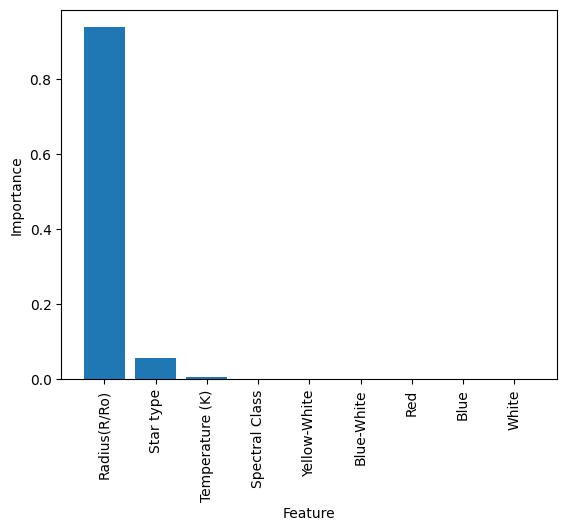

In [10]:
#Splitting the data into the input and output features
x = processed_dataframe.drop(columns=['Absolute magnitude(Mv)', 'Luminosity(L/Lo)'])
y = processed_dataframe['Absolute magnitude(Mv)']

#Splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=90)

#Initializing the RandomForestRegressor
randomForest = RandomForestRegressor(random_state=99)

#Setting up the parameters that will be run through the GridSearchCV for hyperparameter tuning and initializing GridSearchCV
params_dt = {'n_estimators': [25, 50], 'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 6, 9], 'max_leaf_nodes': [None, 10, 20, 30, 40]} 
randomForest_gscv = GridSearchCV(estimator=randomForest, param_grid=params_dt, scoring='neg_mean_squared_error', cv=5)

#Running the model and finding optimal parameters
randomForest_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = randomForest_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Getting the best model and the predictions from it
best_model = randomForest_gscv.best_estimator_
single_tree = randomForest_gscv.best_estimator_[0]
y_pred = best_model.predict(x_test)

#Plotting one of the random forest trees
plt.figure(figsize=[20, 12])
p = tree.plot_tree(single_tree, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Printing the MSE, RMSE, and R^2 of the training and testing data
best_CV_score = randomForest_gscv.best_score_    #Getting the best MSE and printing it
print('MSE of Training: ', abs(best_CV_score))
rmseTrain = np.sqrt(abs(best_CV_score))
print("RMSE of Training:", rmseTrain)
train_r = best_model.score(x_train, y_train)
print("R^2 of Training: ", train_r)
mseTest = metrics.mean_squared_error(y_pred, y_test)
print("MSE of Testing: ", mseTest)
rmseTest = np.sqrt(mseTest)
print("RMSE of Testing:", rmseTest)
test_r = best_model.score(x_test,y_test)
print("R^2 of Testing: ", test_r)

#Getting the feature importance of the model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

### Removing luminosity and radius

Best hyerparameters:
 {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 10, 'n_estimators': 50} 



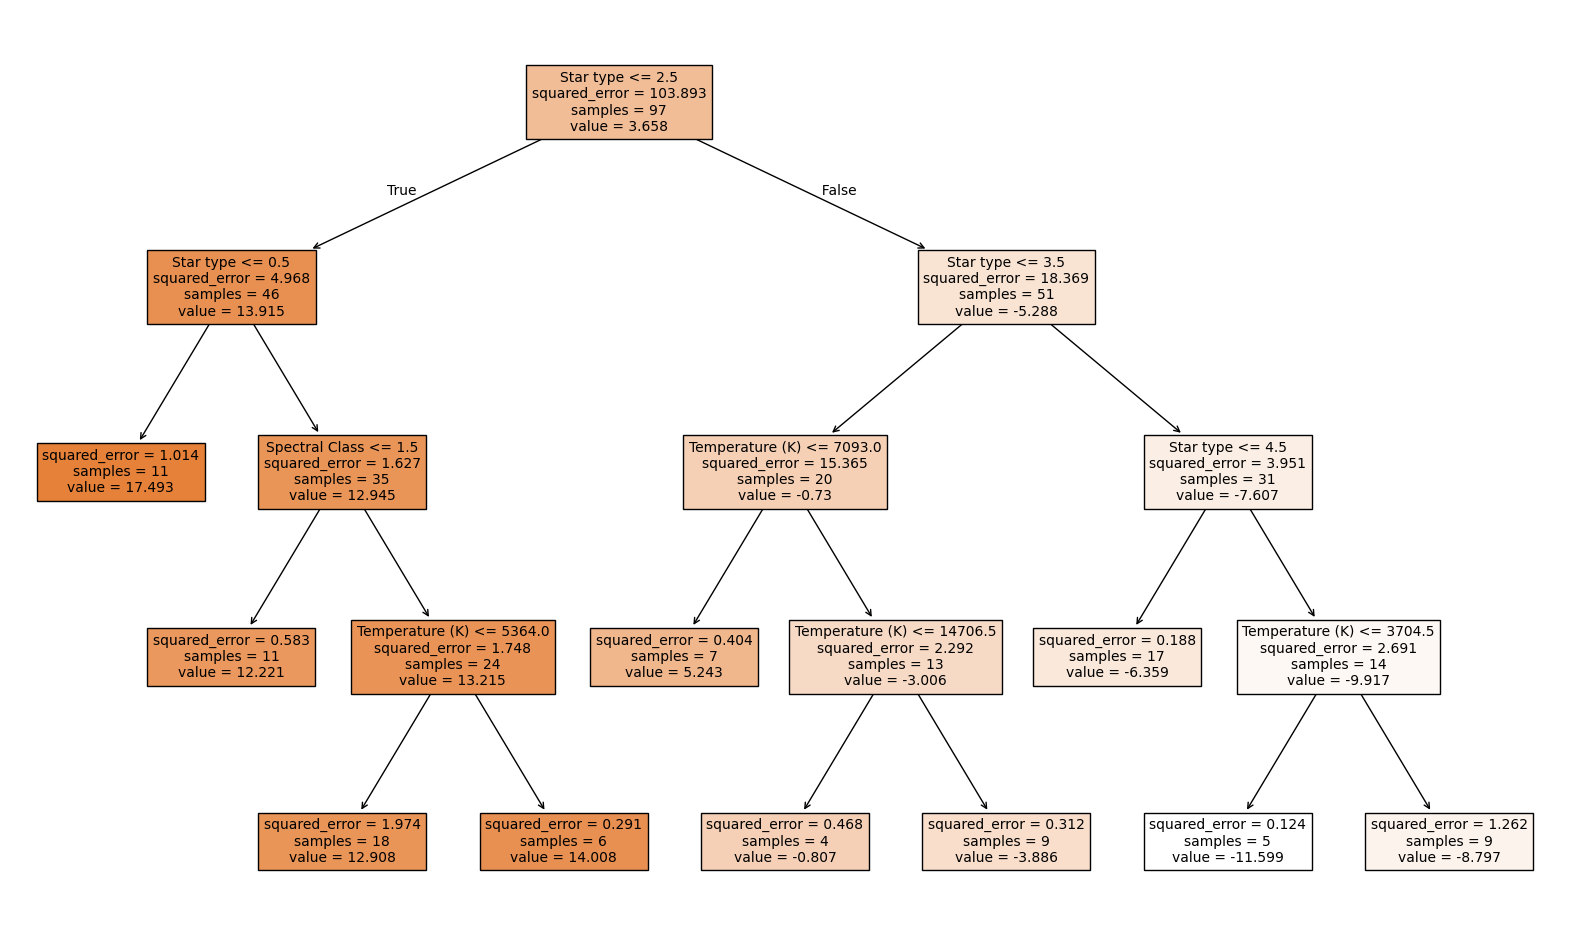

MSE of Training:  1.6298436457806402
RMSE of Training: 1.2766532989737818
R^2 of Training:  0.9905610235242064
MSE of Testing:  1.788967041829479
RMSE of Testing: 1.3375227257244937
R^2 of Testing:  0.9833682395158442
           Feature  Importance
1        Star type    0.970000
0  Temperature (K)    0.013465
7     Yellow-White    0.012653
2   Spectral Class    0.003529
4       Blue-White    0.000259
6            White    0.000094
3             Blue    0.000000
5              Red    0.000000


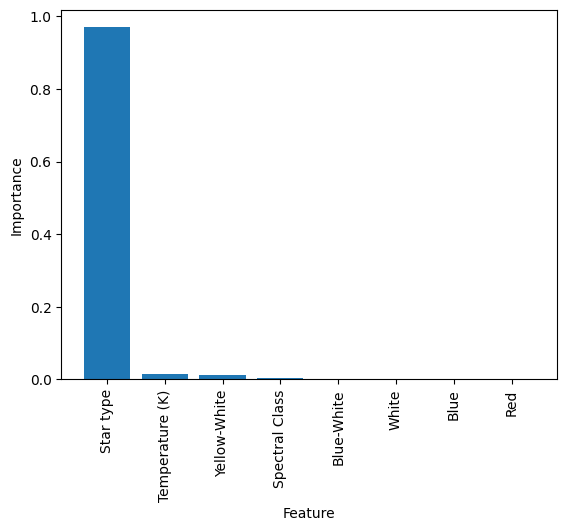

In [11]:
#Splitting the data into input and output features
x = processed_dataframe.drop(columns=['Absolute magnitude(Mv)', 'Radius(R/Ro)', 'Luminosity(L/Lo)'])
y = processed_dataframe['Absolute magnitude(Mv)']

#Splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=90)

#Initializing the RandomForestRegressor
randomForest = RandomForestRegressor(random_state=99)

#Setting up the parameters that are going to be run through GridSearchCV for hyperparameter tuning and initializing GridSearchCV
params_dt = {'n_estimators': [25, 50], 'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 6, 9], 'max_leaf_nodes': [None, 10, 20, 30, 40]} 
randomForest_gscv = GridSearchCV(estimator=randomForest, param_grid=params_dt, scoring='neg_mean_squared_error', cv=5)

#Running the model and finding optimal parameters
randomForest_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = randomForest_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Getting the best model and the predictions from it
best_model = randomForest_gscv.best_estimator_
single_tree = randomForest_gscv.best_estimator_[0]
y_pred = best_model.predict(x_test)

#Plotting one of the random forest trees
plt.figure(figsize=[20, 12])
p = tree.plot_tree(single_tree, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Printing the MSE, RMSE, and R^2 of the training and testing data
best_CV_score = randomForest_gscv.best_score_    #Getting the best MSE and printing it
print('MSE of Training: ', abs(best_CV_score))
rmseTrain = np.sqrt(abs(best_CV_score))
print("RMSE of Training:", rmseTrain)
train_r = best_model.score(x_train, y_train)
print("R^2 of Training: ", train_r)
mseTest = metrics.mean_squared_error(y_pred, y_test)
print("MSE of Testing: ", mseTest)
rmseTest = np.sqrt(mseTest)
print("RMSE of Testing:", rmseTest)
test_r = best_model.score(x_test,y_test)
print("R^2 of Testing: ", test_r)

#Getting the feature importance of the model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

### Removing luminosity, radius, and star type

C:\Users\jaghe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyerparameters:
 {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'n_estimators': 200} 



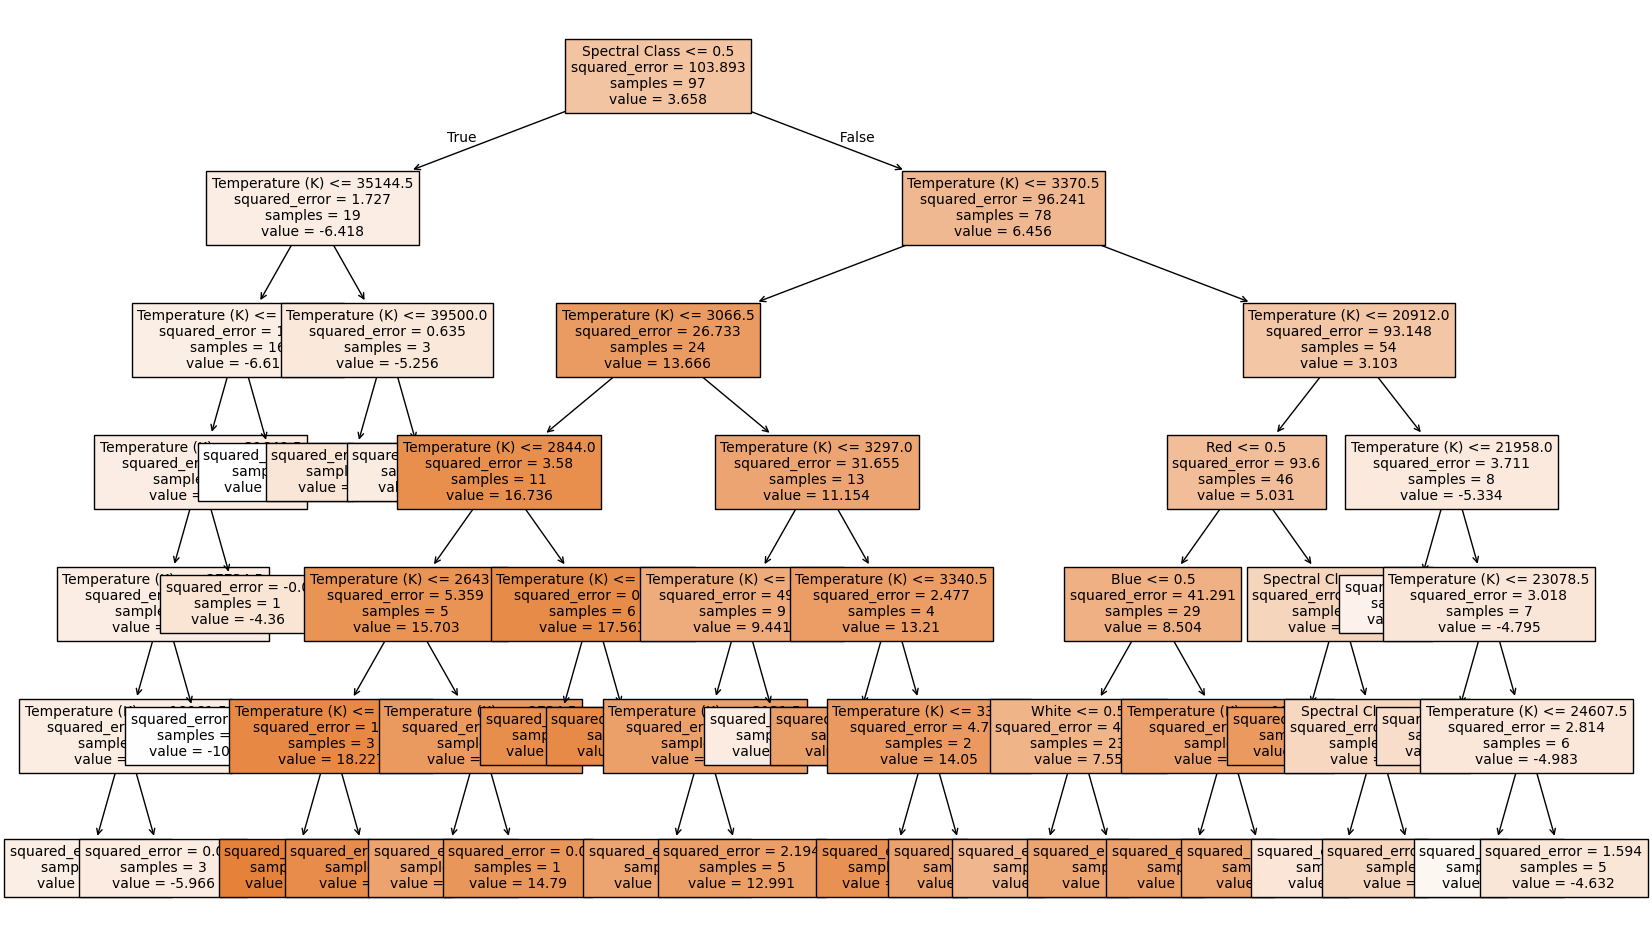

MSE of Training:  55.78775452555483
RMSE of Training: 7.469120063672483
R^2 of Training:  0.736171482835543
MSE of Testing:  80.01306736184937
RMSE of Testing: 8.945002367906303
R^2 of Testing:  0.25613041445190143
           Feature  Importance
0  Temperature (K)    0.637437
1   Spectral Class    0.202083
2             Blue    0.072349
4              Red    0.047792
3       Blue-White    0.015979
5            White    0.015453
6     Yellow-White    0.008907


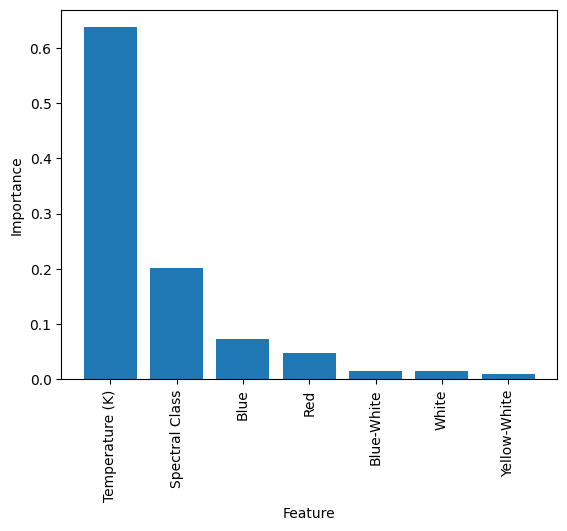

In [12]:
#Splitting the data into input and output features
x = processed_dataframe.drop(columns=['Absolute magnitude(Mv)', 'Radius(R/Ro)', 'Luminosity(L/Lo)', 'Star type'])
y = processed_dataframe['Absolute magnitude(Mv)']

#Splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=90)

#Initializing the RandomForestRegressor
randomForest = RandomForestRegressor(random_state=99)

#Setting up the parameters to be run through GridSearchCV for hyperparameter tuning and initializing GridSearchCV
params_dt = {'n_estimators': [25, 50, 100, 200, 300, 400], 'max_features': ['sqrt', 'log2', None], 'max_depth': [3, 6, 9], 'max_leaf_nodes': [None, 10, 20, 30, 40]} 
randomForest_gscv = GridSearchCV(estimator=randomForest, param_grid=params_dt, scoring='neg_mean_squared_error', cv=5)

#Running the model and finding optimal parameters
randomForest_gscv.fit(x_train, y_train)    #Fitting the model to the training data
best_hyperparams = randomForest_gscv.best_params_    #Getting the best parameters of every run and printing it
print('Best hyerparameters:\n', best_hyperparams, '\n')

#Getting the best model and the predictions from it
best_model = randomForest_gscv.best_estimator_
single_tree = randomForest_gscv.best_estimator_[0]
y_pred = best_model.predict(x_test)

#Plotting one of the random forest trees
plt.figure(figsize=[20, 12])
p = tree.plot_tree(single_tree, feature_names=x_test.columns, filled=True, fontsize=10)
plt.show()

#Printing the MSE, RMSE, and R^2 of the training and testing data
best_CV_score = randomForest_gscv.best_score_    #Getting the best MSE and printing it
print('MSE of Training: ', abs(best_CV_score))
rmseTrain = np.sqrt(abs(best_CV_score))
print("RMSE of Training:", rmseTrain)
train_r = best_model.score(x_train, y_train)
print("R^2 of Training: ", train_r)
mseTest = metrics.mean_squared_error(y_pred, y_test)
print("MSE of Testing: ", mseTest)
rmseTest = np.sqrt(mseTest)
print("RMSE of Testing:", rmseTest)
test_r = best_model.score(x_test,y_test)
print("R^2 of Testing: ", test_r)

#Getting the feature importance of the model and visualizing it
importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': importance})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)
plt.bar(sorted_importance_df['Feature'], sorted_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()